# Hybrid DNN Model for Alzheimer's Disease Prediction

Alzheimer's disease (AD) is a chronic neurodegenerative disease that represents a significant and growing global health challenge. Early and accurate diagnosis is crucial for management and treatment planning, but it remains a complex task due to the multifactorial nature of the disease.

In this notebook, we develop a hybrid deep neural network (DNN) model aimed at predicting the onset and progression of Alzheimer's disease. The "hybrid" aspect of the model refers to its combination of high-capacity deep learning techniques with feature importance analysis, leveraging both data-driven predictions and interpretability.

The goals of this project are:
- To build a robust predictive model capable of identifying patterns associated with AD progression using patient data.
- To utilize feature importance analysis, specifically through SHapley Additive exPlanations (SHAP), to gain insights into which features contribute most significantly to the model's predictions.
- To evaluate the model's performance through rigorous metrics, ensuring its reliability and applicability in a clinical setting.

Through this notebook, we document the entire process from data preprocessing, model construction, and training to the interpretation of the model outputs. Our approach underscores the importance of not only predictive accuracy but also the transparency and interpretability of machine learning models in healthcare.


## Import Libraries

This section loads the necessary Python libraries and modules required for processing the data, building, training, and evaluating the deep neural network model, and interpreting its predictions:

- **NumPy** and **Pandas**: For numerical operations and data manipulation.
- **TensorFlow and Keras**: For building and training the deep neural network.
- **SHAP**: For interpreting the model's predictions through SHapley Additive exPlanations.
- **Scikit-learn**: Provides tools for data preprocessing, cross-validation, and pipeline creation.
- **os**: To handle directory and file operations, crucial for model saving and logging.


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import shap
import os
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Load the Dataset

The dataset is loaded from a CSV file located at `../data/Main.csv`. This dataset contains the data necessary for training and evaluating the Alzheimer's Disease prediction model. It includes various features such as clinical assessments, biomarker data, and imaging data from individuals assessed for Alzheimer's Disease.

In [2]:
# Load the dataset from a CSV file
data_path = "../data/Main.csv"
data = pd.read_csv(data_path)

## Data Preprocessing

In this section, we prepare the dataset for the modeling phase:

### Separate Target and Features
The target variable, 'DX.bl', which represents the diagnostic outcome, is separated from the feature set. This allows for a clear distinction between input features and the output we aim to predict.

### Identify Feature Types
The features are categorized into numerical and categorical types. Numerical columns are those that contain quantitative data, while categorical columns contain qualitative data. This distinction is crucial for applying appropriate preprocessing techniques.

### Preprocessing Steps
A preprocessing pipeline is established for both types of data:
- **Numerical Features**: Missing values are imputed using the median of the column, and data is scaled using standard scaling to normalize the feature values.
- **Categorical Features**: Missing values are filled using the most frequent category, and the categories are then encoded using one-hot encoding to transform them into a format suitable for the model.

The preprocessing steps ensure that the data fed into the model is clean and appropriately formatted, enhancing model performance and stability.

### Convert Processed Data for Model Input
After applying the preprocessing steps, the processed data is converted into a dense array format, making it compatible for input into the machine learning model.

### Feature Names Collection
Post-preprocessing, the names of the new numerical and categorical features are collected for future reference, especially useful during feature importance analysis and model interpretation.


In [3]:
# Separate the target variable 'DX.bl' from the features
y = data['DX.bl']
X = data.drop(['DX.bl'], axis=1)

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

# Create preprocessing steps for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)

# Apply the preprocessing pipeline to the feature data and convert to a dense array
X_processed = preprocessor.fit_transform(X).toarray()

# Get feature names for the processed columns
new_numerical_features = numerical_cols.tolist()
new_categorical_features = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols).tolist()
new_features = new_numerical_features + new_categorical_features
joblib.dump(preprocessor, '../models/preprocessor.joblib')  # Save feature transformer

['../models/preprocessor.joblib']

## Encoding the Target Variable

The target variable requires encoding to transform it from categorical labels into a numerical format that can be processed by the neural network:

### Label Encoding
First, the target variable 'DX.bl' is transformed using Label Encoding. This converts each unique label into a specific integer. This step is crucial for preparing categorical labels for further encoding techniques and ensuring compatibility with various machine learning algorithms.

### One-Hot Encoding for Multiclass Classification
If the prediction task involves multiclass classification (i.e., predicting more than two classes), the integer-encoded labels are further transformed using One-Hot Encoding. This process converts the integer labels into a binary matrix representation. Each column in this matrix represents one category of the data, with only one active state (`1`) per row, indicating the presence of a particular class. This method is essential for models that require a clear distinction between multiple classes, enhancing the model's ability to classify accurately.

The resulting encoded labels (`y_onehot`) are now ready for use in training the deep learning model, providing a clear and effective way for the network to predict multiple classes.


In [4]:
# Encode the target variable for classification
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# If the task is multiclass classification, use one-hot encoding
y_onehot = to_categorical(y_encoded)
class_labels = le.classes_
joblib.dump(le, '../models/label_encoder.joblib')  # Save label encoder

['../models/label_encoder.joblib']

## Data Splitting for Model Training and Evaluation

To ensure the robustness of the model and evaluate its performance effectively, the dataset is split into training, validation, and test sets:

### Training and Test Split
The data is initially split into training and test sets, with 20% of the data reserved for the test set. This split is controlled by a random state to ensure reproducibility of the results. The test set will be used to evaluate the model's performance after it has been trained and validated, providing an unbiased assessment of its generalization capability.

### Training and Validation Split
The training data is further divided to include a validation set, which accounts for 25% of the training data. This validation set is crucial for tuning the model's parameters and preventing overfitting. It provides a reliable dataset for validating the model's performance during training, allowing adjustments before the final evaluation on the test set.

These splits help in training a well-generalized model and ensure that the performance metrics reflect how well the model can perform on unseen data.


In [5]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_onehot, test_size=0.2, random_state=42)
# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Model Architecture Definition

This section defines the architecture of the deep neural network used for predicting Alzheimer's Disease. The function `create_model` sets up a sequential model with multiple dense layers and dropout layers to prevent overfitting:

- **Input Layer**: Specifies the number of features the model will accept.
- **Hidden Layers**: Includes three hidden layers with decreasing units (128, 64, 32) using ReLU activation to introduce non-linearity.
- **Dropout Layers**: Placed after each hidden layer to reduce overfitting by randomly setting a fraction of input units to 0 during training.
- **Output Layer**: Uses a softmax activation function to output probabilities across the `num_classes`, suitable for multiclass classification.

The model is compiled with the Adam optimizer and categorical crossentropy loss function, which is appropriate for multiclass classification tasks.

In [6]:
def create_model(input_shape, num_classes):
    # Initialize a sequential model and add layers
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation='relu'),  # First hidden layer with ReLU activation
        Dropout(0.2),  # Dropout to prevent overfitting
        Dense(64, activation='relu'),  # Second hidden layer
        Dropout(0.2),  # Another dropout layer
        Dense(32, activation='relu'),  # Third hidden layer
        Dropout(0.2),  # Final dropout layer
        Dense(num_classes, activation='softmax')  # Output layer with softmax activation for multiclass classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## K-Fold Cross-Validation for Model Evaluation

To ensure the model's robustness and generalizability, k-fold cross-validation is employed. This method enhances the validation process by dividing the data into `k` subsets and iteratively training the model `k` times. Each time, one subset is used as the test set and the others as the training set.

### Setup
- **Number of Folds**: 5 (This helps in reducing the variance of the model's performance estimates.)
- **Shuffling**: Data is shuffled to ensure random distribution across folds.
- **Random State**: Fixed to ensure reproducibility of results.

### Model Training and Validation Loop
- For each fold, a fresh instance of the model is created and compiled.
- Training is monitored with an Early Stopping callback to halt training if the validation loss does not improve, thus preventing overfitting.
- A ModelCheckpoint callback is used to save the best version of the model for each fold based on the minimum validation loss.

### Model Evaluation
- After training, each model is evaluated on its respective test fold.
- The loss and accuracy for each fold are recorded and reported.

### Results
- After all folds are processed, the average and standard deviation of the accuracy and loss across all folds are computed and displayed. This provides a comprehensive view of the model’s performance and its variability across different subsets of the data.

The use of k-fold cross-validation in this context is particularly valuable in assessing the model's ability to generalize to new data, an essential aspect of a reliable predictive model in healthcare.


In [7]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the base directory where the models will be saved
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)  

fold_no = 1
loss_per_fold = []
accuracy_per_fold = []

for train, test in kfold.split(X_processed, y_onehot):
    # Create and compile the model
    model = create_model(X_processed.shape[1], y_onehot.shape[1])

    # Setup callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    
    # Define the path for the ModelCheckpoint
    filepath = os.path.join(models_dir, f'best_model_fold_{fold_no}.h5')
    
    model_checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

    print(f'Training for fold {fold_no} ...')
    history = model.fit(X_processed[train], y_onehot[train],
                        batch_size=32,
                        epochs=100,
                        validation_data=(X_processed[test], y_onehot[test]),
                        callbacks=[early_stopping, model_checkpoint],
                        verbose=2)

    # Evaluate the model
    scores = model.evaluate(X_processed[test], y_onehot[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    loss_per_fold.append(scores[0])
    accuracy_per_fold.append(scores[1] * 100)

    fold_no += 1

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold):.2f}% (+- {np.std(accuracy_per_fold):.2f})')
print(f'> Loss: {np.mean(loss_per_fold):.2f}')
print('------------------------------------------------------------------------')

Training for fold 1 ...
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.16294, saving model to ../models\best_model_fold_1.h5
279/279 - 3s - loss: 0.5968 - accuracy: 0.7826 - val_loss: 0.1629 - val_accuracy: 0.9390 - 3s/epoch - 9ms/step
Epoch 2/100


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



Epoch 2: val_loss improved from 0.16294 to 0.07863, saving model to ../models\best_model_fold_1.h5
279/279 - 2s - loss: 0.1525 - accuracy: 0.9491 - val_loss: 0.0786 - val_accuracy: 0.9735 - 2s/epoch - 6ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.07863 to 0.06341, saving model to ../models\best_model_fold_1.h5
279/279 - 2s - loss: 0.0628 - accuracy: 0.9804 - val_loss: 0.0634 - val_accuracy: 0.9744 - 2s/epoch - 6ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.06341 to 0.04268, saving model to ../models\best_model_fold_1.h5
279/279 - 2s - loss: 0.0353 - accuracy: 0.9901 - val_loss: 0.0427 - val_accuracy: 0.9857 - 2s/epoch - 6ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.04268 to 0.04110, saving model to ../models\best_model_fold_1.h5
279/279 - 2s - loss: 0.0218 - accuracy: 0.9946 - val_loss: 0.0411 - val_accuracy: 0.9857 - 2s/epoch - 6ms/step
Epoch 6/100

Epoch 6: val_loss improved from 0.04110 to 0.02031, saving model to ../models\best_model_fold_1.h5
279/279 

## Analysis of K-Fold Cross-Validation Results

### Summary of Results
The model achieved an exceptionally high average accuracy of 99.67% with a very low standard deviation of 0.18% across all folds. This indicates a highly effective model with consistent performance across different subsets of the data. The average loss was remarkably low at 0.01, further confirming the model's efficacy in accurately predicting Alzheimer's Disease from the given features.

### Interpretation
- **High Accuracy**: The high average accuracy suggests that the model is very effective at classifying the correct stages of Alzheimer's Disease. The low variability (standard deviation) in accuracy across folds underscores the model’s stability and robustness, which are crucial for clinical applications.
  
- **Low Loss**: The minimal loss indicates that the model’s predictions are very close to the actual data, showcasing the model's ability to generalize well without overfitting.

### Conclusions
These results validate the model's reliability and suitability for potentially aiding in the diagnostic process of Alzheimer's Disease. Given its high accuracy and low loss, it could be considered for further validation with external datasets or potentially in clinical trials to assess its practical utility in a real-world setting.

The consistent performance across different data splits suggests that the model could reliably be used in diverse clinical scenarios without the risk of significant performance drops.


## Saving the Final Model

After completing the training and validation processes, and confirming the model's robust performance, it is essential to save the final model. This allows the model to be reused, deployed, or further evaluated without the need to retrain.

### Model Saving
- The model is saved using TensorFlow's `save` method, which preserves not only the model architecture and weights but also its compilation information (including the optimizer, configured loss, and metrics).
- Saving in TensorFlow's format ensures that the model can easily be reloaded in the exact state it was saved, facilitating both reproducibility and deployment.

This step finalizes the modeling process, securely storing the trained model for future application.


In [8]:
# Define the path for saving the final model, use the .keras extension
final_model_path = os.path.join(models_dir, 'final_model_saved')

model.save(final_model_path, save_format='tf')

INFO:tensorflow:Assets written to: ../models\final_model_saved\assets


INFO:tensorflow:Assets written to: ../models\final_model_saved\assets


In [9]:
model = load_model(final_model_path)

## Feature Importance Analysis with SHAP

Understanding the contribution of each feature to the model's predictions is crucial, especially in healthcare applications where interpretability can inform clinical decisions. We employ SHAP (SHapley Additive exPlanations), a game theory approach to explain the output of machine learning models.

### Explainer Setup
- **Background Data**: A subset of the training data (`X_train`) is used to initialize the SHAP explainer. This subset is sampled to include 100 instances, providing a representative background for the model's data distribution.
- **Explainer Initialization**: The `DeepExplainer` from SHAP is utilized, which is specifically designed for deep learning models. It leverages the background dataset to approximate the SHAP values.

### Calculate SHAP Values
- **Subset Sampling**: SHAP values are computed for a randomly sampled subset of 100 instances from the test dataset (`X_test`). This approach ensures that the explanations are manageable and computationally feasible while still providing insight into the model's behavior on unseen data.

### Visualization of SHAP Values
- **Summary Plot**: The SHAP summary plot provides a global view of the feature importances. It shows how much each feature contributes to increasing or decreasing the prediction output. The features are ranked by their importance, and their impact distribution across the dataset is displayed.
- **Feature Names**: Custom feature names (`new_features`) are used in the plot to clearly identify each feature, enhancing the interpretability of the plot.

This analysis not only highlights which features are most influential but also how they influence the model's predictions, adding an important layer of transparency to our predictive model.


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


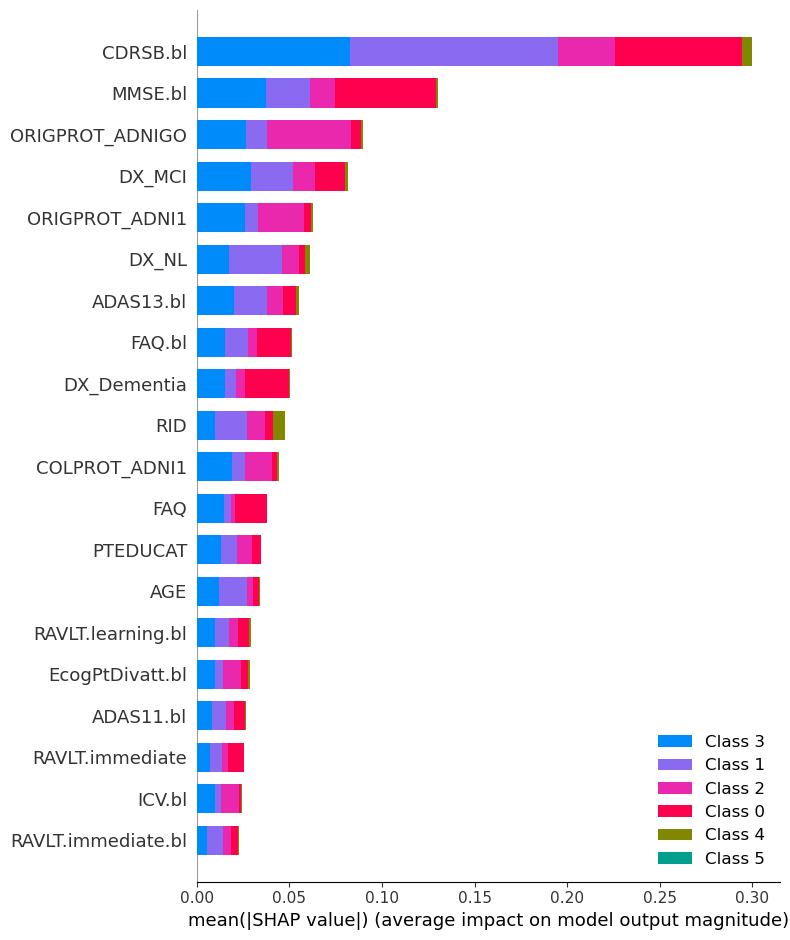

In [10]:
# Explainer setup
background = shap.sample(X_train, 100) 
explainer = shap.DeepExplainer(model, background)

# Calculate SHAP values for a subset of the test data
shap_values = explainer.shap_values(shap.sample(X_test, 100))

# Visualize the SHAP values
shap.summary_plot(shap_values, shap.sample(X_test, 100), feature_names=new_features)

## Insights from SHAP Summary Plot

The SHAP summary plot provides a visual representation of feature importances for the Alzheimer's Disease classification model. Each row corresponds to a feature, and the color-coded segments represent the impact of these features on the model's output across different classes.

### Key Observations

- **Cognitive Test Scores**: Features such as `CDRSB.bl`, `MMSE.bl`, and `ADAS13.bl` are prominently placed at the top of the plot, indicating their significant influence on the model's predictions. These features, associated with cognitive test scores, are crucial for understanding the disease's impact on cognitive functions.

- **Class-Differential Impact**: The spread of colors across the bars for each feature illustrates that the influence of certain features varies by class. For instance, `CDRSB.bl` shows a marked impact on Class 0 and Class 3, suggesting its relevance to the early and possibly intermediate stages of the disease.

- **Biomarkers**: Anatomical features such as `Hippocampus.bl` and `Fusiform.bl` also demonstrate substantial importance. The hippocampus, known to be affected in Alzheimer's Disease, is validated by the model as a significant feature, aligning with current medical understanding.

- **Variability in Influence**: The variability of feature impact across classes highlights the multifactorial nature of Alzheimer's Disease and reinforces the need for a nuanced approach to diagnosis and treatment.

- **Potential for Clinical Application**: The diversity and strength of feature importance offer insights that could be leveraged for clinical applications, such as targeted screening and personalized treatment plans based on patient-specific profiles.

### Conclusion

The model identifies a range of features with varying degrees of importance, reflecting the complex interplay of cognitive, genetic, and neuroanatomical factors in Alzheimer's Disease. This analysis underscores the potential of machine learning in enhancing our understanding and prediction of the disease, though clinical validation remains essential to ensure relevance and accuracy.
